In [25]:
#### !pip install -U scikit-learn


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



# Loading preprocessed data


data = np.load("/Users/sauravbania/My Projects/Uncertainty-Quantification-CMS/processed/processed_dataset.npz")

X_val = data["X_val"]
y_val = data["y_val"]
pT_quark = data["pT_quark"]
pT_gluon = data["pT_gluon"]
eta_quark = data["eta_quark"]
eta_gluon = data["eta_gluon"]
azm_quark = data["azm_quark"]
azm_gluon = data["azm_gluon"]
pT_val_nonzero = data["pT_val_nonzero"]
eta_val_nonzero= data["eta_val_nonzero"]
azm_val_nonzero  = data["azm_val_nonzero"]

#### Multiplicity

I am defining the "jet_multiplicity(X_val, y_val, label)" function here which counts the number of non-zero particles per jet. The multiplicities are plotted in **[datasets.ipynb](datasets.ipynb)** notebook. 

In [35]:
def jet_multiplicity(X_val, y_val, label):
    """Counts the number of non-zero particles per jet and returns a list.
    Args:
        X_val (np.ndarray): Input array (n_jets, n_particles, 3)
        y_val (np.ndarray): Labels (0 = gluon, 1 = quark)
        label (int): 0 = gluon jets, 1 = quark jets
    Returns:
        list (int): list of number of non-zero particles per jet.
    """
    val_mul = []
    for i in range(len(y_val)):
        if y_val[i] == label:
            count = np.sum(X_val[i, :, 0] > 0)  # Count non-zero pT particles
            val_mul.append(count)
    return val_mul

q_mul = jet_multiplicity(X_val, y_val, 1)
g_mul = jet_multiplicity(X_val, y_val, 0)


#### Mean $p_T$ per jet

In [36]:
def mean_pT_per_jet(X_val, y_val, label):
    """Computes the mean pT values per jet for quark and gluon jets and returns a list.
    Args:
        X_val (np.ndarray): Input array (n_jets, n_particles, 3)
        y_val (np.ndarray): Labels (0 = gluon, 1 = quark)
        label (int): 0 = gluon jets, 1 = quark jets
    Returns:
        list[np.ndarray]: List of mean pT values (one per jet).
    """
    mean_val = []
    for i in range(len(y_val)):
        if y_val[i] == label:
            pT_nonzero = X_val[i, X_val[i, :, 0] > 0, 0]
            if len(pT_nonzero) > 0:
                mean_val.append(pT_nonzero)
    return mean_val

pT_mean_quark = mean_pT_per_jet(X_val, y_val, 1)
pT_mean_gluon = mean_pT_per_jet(X_val, y_val, 0)

# plt.figure(figsize=(8, 6))
# plt.hist(pT_mean_quark, bins=50, alpha=0.5, label="Gluon Jets", color="blue")
# plt.hist(pT_mean_gluon, bins=50, alpha=0.5, label="Quark Jets", color="red")
# plt.xlabel('Mean pT per jet')
# plt.ylabel('Number of Jets')
# plt.xscale('log')
# plt.yscale('log')
# plt.title("Mean pT per jet of Quark and Gluon jets")
# plt.legend()
# plt.show()
# One can use the above code to plot the mean pT values.
# If using the above code then do not forget to flatten the pT_mean_quark and pT_mean_gluon as:
# pT_mean_quark = np.concatenate(mean_pT_per_jet(X_val, y_val, 1))
# pT_mean_gluon = np.concatenate(mean_pT_per_jet(X_val, y_val, 0))

#### Plotting the quark and gluon mean $p_{T}$ distributions does not give us any insight, as all particles in a jet do not carry momentum equally. Two jets can have the same mean $p_{T}$, (say), with one having *few energetic particles and many soft ones* while the other having *most particles near the mean*. But these two jets won't behave the same as their momentum spread is different. 

So, I am now thinking of measuring the **spread of $p_{T}$** within each jet, i.e., the **jet width** via **pT-weighted standard deviation**. This will tell us how far individual particles deviate from the jet's center direction in terms of **rapidity ($\eta$)** and **azimuthal angle ($\phi$)** where the deviations are weighted by each particle's $p_{T}$. 

To measure the spread of $p_{T}$ within each jet, we first have to extract the non-zero $p_{T}, \eta, \phi$ values. We have already extrated the non-zero values of the features in **[datasets.ipynb](datasets.ipynb)** notebook and loaded in this notebook as pT_val_nonzero, eta_val_nonzero and azm_val_nonzero, but we can't use it as they are flattened arrays. So, we first extract the non-zero values. Then we compute the $p_{T}$ weighted mean of $\eta$ and $\phi$ with the formula given as:
$$
\bar{\eta} = \frac{\sum p_{T} . \eta}{\sum p_{T}}
$$
and 
$$
\bar{\phi} = \frac{\sum p_{T} . \phi}{\sum p_{T}}
$$

This will tell us about the center of the jet, giving more weight to higher-energy particles. 

Next we compute the $p_{T}$ weighted variance (***the spread***) as:
$$
\sigma_{\eta}^{2} = \frac{\sum p_{T} . (\eta - \bar{\eta})^{2}}{\sum p_{T}}
$$
and 
$$
\sigma_{\phi}^{2} = \frac{\sum p_{T} . (\phi - \bar{\phi})^{2}}{\sum p_{T}}
$$

Finally, we compute the square root to get the standard deviation:
$$
\text{jet width in } \eta = \sqrt{\sigma_\eta^2}
$$
$$
\text{jet width in } \phi = \sqrt{\sigma_\phi^2}
$$

 eta_width_quark range: Min value: 0.0022104682000186693, Max value: 0.21724984441007236
 phi_width_quark range: Min value: 0.0033118093386316776, Max value: 0.22525506026431205
 eta_width_gluon range: Min value: 0.006095739429987281, Max value: 0.22340998985143143
 phi_width_gluon range: Min value: 0.006692634887928544, Max value: 0.22520798698650157


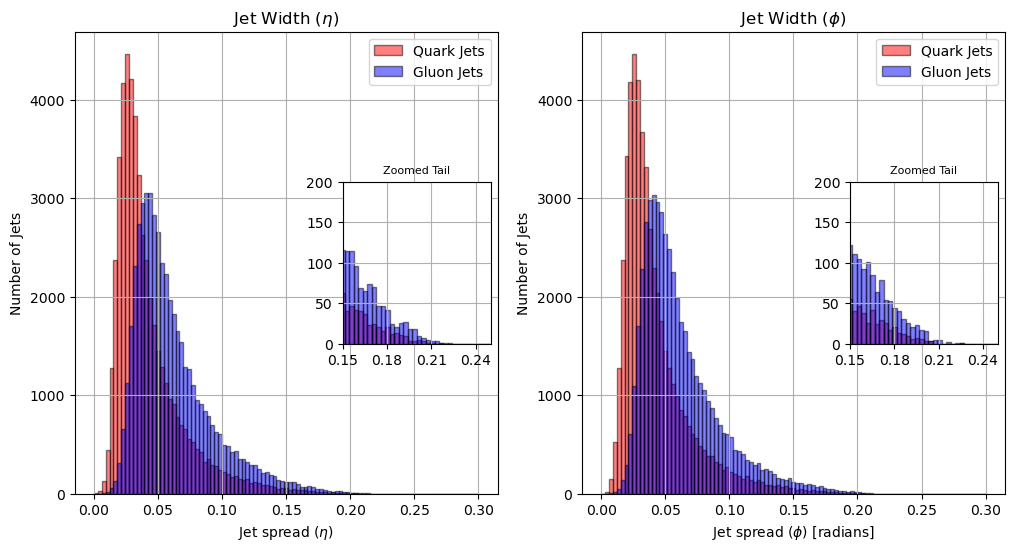

In [37]:
#### Defining function: jet_width


def jet_width(X_val, y_val, label):
    """
    Computes the pT-weighted jet width (standard deviation) in η and φ 
    for quark or gluon jets.

    Args:
        X_val (np.ndarray): Input array (n_jets, n_particles, 3)
        y_val (np.ndarray): Labels (0 = gluon, 1 = quark)
        label (int): 0 = gluon jets, 1 = quark jets

    Returns:
        Tuple[List[float], List[float]]: Two lists containing pT-weighted
        standard deviations per jet for η and φ respectively.
    """
    jet_width_eta = []
    jet_width_phi = []
    
    for i in range(len(y_val)):
        if y_val[i] == label:
            # Extracting non-zero values and filtering out zero-padded values
            pT = X_val[i, X_val[i, :, 0]> 0, 0]
            eta = X_val[i, X_val[i, :, 0]> 0, 1]
            phi = X_val[i, X_val[i, :, 0]> 0, 2]
        
            if pT.size > 0:
                # Computing eta_bar and phi_bar (pT weighted mean)
                eta_bar = np.sum(pT * eta) / np.sum(pT)
                phi_bar = np.sum(pT * phi) / np.sum(pT)

                # Computing jet width by taking the square root pT weighted variance
                weighted_eta_std = np.sqrt(np.sum(pT * (eta - eta_bar)**2)/ np.sum(pT))
                weighted_phi_std = np.sqrt(np.sum(pT * (phi - phi_bar)**2)/ np.sum(pT))
            
                jet_width_eta.append(weighted_eta_std)
                jet_width_phi.append(weighted_phi_std)
            
    return jet_width_eta, jet_width_phi

eta_width_quark, phi_width_quark = jet_width(X_val, y_val, 1)
eta_width_gluon, phi_width_gluon = jet_width(X_val, y_val, 0)

# Now we have per-jet spread information for both quark and gluon jets. We have 4 lists eta_width_quark, phi_width_quark
# eta_width_gluon, phi_width_gluon, where each contains per-jet standard deviations of eta or phi - a measure of jet spread.
# These are numerical values, one per jet. 

# Let's start the visualisation part.
print(f" eta_width_quark range: Min value: {np.min(eta_width_quark)}, Max value: {np.max(eta_width_quark)}")
print(f" phi_width_quark range: Min value: {np.min(phi_width_quark)}, Max value: {np.max(phi_width_quark)}")

print(f" eta_width_gluon range: Min value: {np.min(eta_width_gluon)}, Max value: {np.max(eta_width_gluon)}")
print(f" phi_width_gluon range: Min value: {np.min(phi_width_gluon)}, Max value: {np.max(phi_width_gluon)}")


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
bins = np.linspace(0, 0.3, 100)

ax[0].hist(eta_width_quark, bins=bins, alpha=0.5, label="Quark Jets", color="red", edgecolor='black')
ax[0].hist(eta_width_gluon, bins=bins, alpha=0.5, label="Gluon Jets", color="blue", edgecolor='black')
ax[0].set_xlabel('Jet spread ($\eta$)')
ax[0].set_ylabel('Number of Jets')
ax[0].set_title("Jet Width ($\eta$)")
ax[0].legend()
ax[0].grid(True)


ax[1].hist(phi_width_quark, bins=bins, alpha=0.5, label="Quark Jets", color="red", edgecolor='black')
ax[1].hist(phi_width_gluon, bins=bins, alpha=0.5, label="Gluon Jets", color="blue", edgecolor='black')
ax[1].set_xlabel('Jet spread ($\phi$) [radians]')
ax[1].set_ylabel('Number of Jets')
ax[1].set_title("Jet Width ($\phi$)")
ax[1].legend()
ax[1].grid(True)


# Importing inset_axis
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Creating inset inside ax[0]
inset_ax1 = inset_axes(ax[0], width="35%", height="35%", loc="center right")

# Plotting same data inside inset
inset_ax1.hist(eta_width_quark, bins=bins,alpha=0.5, label="Quark Jets", color="red", edgecolor='black')
inset_ax1.hist(eta_width_gluon, bins=bins, alpha=0.5, label="Gluon Jets", color="blue", edgecolor='black')

# Zoom limits
inset_ax1.set_xlim(0.15, 0.25)
inset_ax1.set_ylim(0, 200)

# Optional: make it pretty
inset_ax1.set_xticks([0.15, 0.18, 0.21, 0.24])
inset_ax1.set_yticks([0, 50, 100, 150, 200])
inset_ax1.set_title("Zoomed Tail", fontsize=8)
inset_ax1.grid(True)

# Similarly for the second plot:
inset_ax2 = inset_axes(ax[1], width="35%", height="35%", loc="center right")

inset_ax2.hist(phi_width_quark, bins=bins,alpha=0.5, label="Quark Jets", color="red", edgecolor='black')
inset_ax2.hist(phi_width_gluon, bins=bins, alpha=0.5, label="Gluon Jets", color="blue", edgecolor='black')

inset_ax2.set_xlim(0.15, 0.25)
inset_ax2.set_ylim(0, 200)
inset_ax2.set_title("Zoomed Tail", fontsize=8)
inset_ax2.grid(True)

#Ticks
inset_ax2.set_xticks([0.15, 0.18, 0.21, 0.24])
inset_ax2.set_yticks([0, 50, 100, 150, 200])


# # Marking inset
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset
# mark_inset(ax[0], inset_ax, loc1=2, loc2=4, fc="none", ec="gray", linestyle="--")
# mark_inset(ax[1], inset_ax, loc1=2, loc2=4, fc="none", ec="gray", linestyle="--")


#### **Descriptive Statistics**


In [29]:

from scipy.stats import skew, kurtosis
import pandas as pd

def summarize_distribution(values):
    mean_val = np.mean(values)
    median_val = np.median(values)
    std_val = np.std(values)
    skew_val = skew(values)
    kurtosis_val = kurtosis(values)
    return mean_val, median_val, std_val, skew_val, kurtosis_val

# # For eta
# print(f"""eta_width_quark stats. - 
# Mean: {summarize_distribution(eta_width_quark)[0]:.4f},
# Median: {summarize_distribution(eta_width_quark)[1]:.4f},
# Std: {summarize_distribution(eta_width_quark)[2]:.4f}, 
# Skew: {summarize_distribution(eta_width_quark)[3]:.4f},
# Kurtosis: {summarize_distribution(eta_width_quark)[4]:.4f}
# """)
# print(f"""eta_width_gluon stats. - 
# Mean: {summarize_distribution(eta_width_gluon)[0]:.4f},
# Median: {summarize_distribution(eta_width_gluon)[1]:.4f},
# Std: {summarize_distribution(eta_width_gluon)[2]:.4f}, 
# Skew: {summarize_distribution(eta_width_gluon)[3]:.4f},
# Kurtosis: {summarize_distribution(eta_width_gluon)[4]:.4f}
# """)

# # For phi
# print(f"""phi_width_quark stats. - 
# Mean: {summarize_distribution(phi_width_quark)[0]:.4f},
# Median: {summarize_distribution(phi_width_quark)[1]:.4f},
# Std: {summarize_distribution(phi_width_quark)[2]:.4f}, 
# Skew: {summarize_distribution(phi_width_quark)[3]:.4f},
# Kurtosis: {summarize_distribution(phi_width_quark)[4]:.4f}
# """)
# print(f"""phi_width_gluon stats. - 
# Mean: {summarize_distribution(phi_width_gluon)[0]:.4f},
# Median: {summarize_distribution(phi_width_gluon)[1]:.4f},
# Std: {summarize_distribution(phi_width_gluon)[2]:.4f}, 
# Skew: {summarize_distribution(phi_width_gluon)[3]:.4f},
# Kurtosis: {summarize_distribution(phi_width_gluon)[4]:.4f}
# """)

# Printing the statistics in tabular format
jet_stats = {
    "Metric": ["Mean", "Median", "Std", "Skew", "Kurtosis"],
    "eta_width_quark": summarize_distribution(eta_width_quark),
    "eta_width_gluon": summarize_distribution(eta_width_gluon),
    "phi_width_quark": summarize_distribution(phi_width_quark),
    "phi_width_gluon": summarize_distribution(phi_width_gluon)
}

jet_stats_df = pd.DataFrame(jet_stats).round(4)
# jet_stats_df.style.set_caption("Jet Width Summary Stats") \
#     .highlight_max(axis=1) \
#     .format("{:.4f}") \
#     .background_gradient() \
#     .bar() \


print(jet_stats_df.to_string(index=False))

        

  Metric  eta_width_quark  eta_width_gluon  phi_width_quark  phi_width_gluon
    Mean           0.0424           0.0617           0.0423           0.0618
  Median           0.0339           0.0533           0.0339           0.0534
     Std           0.0271           0.0307           0.0271           0.0309
    Skew           1.9538           1.3924           1.9642           1.4206
Kurtosis           4.7027           2.0864           4.7463           2.2005


#### Summary Statistics: Jet Widths in $\eta$ and $\phi$

We computed summary statistics (mean, median, standard deviation, skewness, and kurtosis) for the $\eta$- and $\phi$-widths of quark and gluon jets. The results offer important insights into the spread and shape of these jet width distributions.

### $\eta$-Width Summary:
| Statistic     | Quark Jets | Gluon Jets |
|---------------|------------|------------|
| **Mean**      | 0.0424     | 0.0617     |
| **Median**    | 0.0339     | 0.0533     |
| **Std Dev**   | 0.0271     | 0.0307     |
| **Skewness**  | 1.9538     | 1.3924     |
| **Kurtosis**  | 4.7027     | 2.0864     |

### $\phi$-Width Summary:
| Statistic     | Quark Jets | Gluon Jets |
|---------------|------------|------------|
| **Mean**      | 0.0423     | 0.0618     |
| **Median**    | 0.0339     | 0.0534     |
| **Std Dev**   | 0.0271     | 0.0309     |
| **Skewness**  | 1.9642     | 1.4206     |
| **Kurtosis**  | 4.7463     | 2.2005     |

---

### Interpretation Guidance:
- **Mean > Median** and **Positive Skewness** in all cases indicates right-skewed distributions.
- **Higher skewness and kurtosis** for quark jets implies:
  - More extreme outliers
  - Sharper peak and longer tail
- These trends are consistent across both $\eta$ and $\phi$, suggesting physically meaningful differences in jet collimation between quarks and gluons.

---

Let us now proceed to visually confirm this behavior using **Empirical CDFs**, and quantify the difference using a **KS-test**.

---


KS Statistic (quark) : 0.3717
P-value (quark) : 0.000000
KS Statistic (gluon) : 0.3742
P-value (gluon) : 0.000000


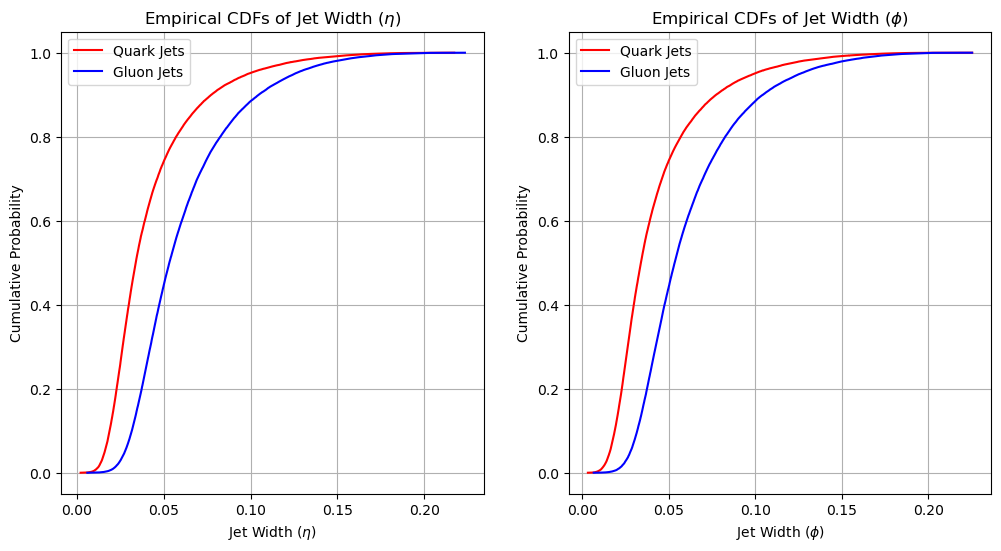

In [30]:


from scipy.stats import ks_2samp

# sorting and computing the empirical cdf
def empirical_cdf_jetwise(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

# For eta
eta_width_quark_sorted, eta_wid_qua_cdf = empirical_cdf_jetwise(eta_width_quark)
eta_width_gluon_sorted, eta_wid_glu_cdf = empirical_cdf_jetwise(eta_width_gluon)

# For phi
phi_width_quark_sorted, phi_wid_qua_cdf = empirical_cdf_jetwise(phi_width_quark)
phi_width_gluon_sorted, phi_wid_glu_cdf = empirical_cdf_jetwise(phi_width_gluon)

# Plot the CDFs
fig, ax = plt.subplots(1, 2, figsize=(12,6))


ax[0].plot(eta_width_quark_sorted, eta_wid_qua_cdf, label="Quark Jets", color="red")
ax[0].plot(eta_width_gluon_sorted, eta_wid_glu_cdf, label="Gluon Jets", color="blue")
ax[0].set_xlabel("Jet Width ($\eta$)")
ax[0].set_ylabel("Cumulative Probability")
ax[0].set_title("Empirical CDFs of Jet Width ($\\eta$)")
ax[0].legend()
ax[0].grid(True)

ax[1].plot(phi_width_quark_sorted, phi_wid_qua_cdf, label="Quark Jets", color="red")
ax[1].plot(phi_width_gluon_sorted, phi_wid_glu_cdf, label="Gluon Jets", color="blue")
ax[1].set_xlabel("Jet Width ($\phi$)")
ax[1].set_ylabel("Cumulative Probability")
ax[1].set_title("Empirical CDFs of Jet Width ($\\phi$)")
ax[1].legend()
ax[1].grid(True)



# KS Test
ks_stat_quark, p_value_quark = ks_2samp(eta_width_quark, eta_width_gluon)
ks_stat_gluon, p_value_gluon = ks_2samp(phi_width_quark, phi_width_gluon)

print(f"KS Statistic (quark) : {ks_stat_quark:.4f}")
print(f"P-value (quark) : {p_value_quark:.6f}")

print(f"KS Statistic (gluon) : {ks_stat_gluon:.4f}")
print(f"P-value (gluon) : {p_value_gluon:.6f}")


#### Kolmogorov–Smirnov Test on Jet Width Distributions

To quantify the statistical difference between quark and gluon jet widths in both $\eta$ and $\phi$, I computed the **empirical cumulative distribution functions (CDFs)** and conducted a **two-sample Kolmogorov–Smirnov (KS) test**.

### KS Test Results:

| Metric | KS Statistic | p-value |
|--------|--------------|---------|
| **$\eta$ Width** | 0.3717 | < 0.000001 |
| **$\phi$ Width** | 0.3742 | < 0.000001 |

- **KS Statistic** represents the maximum distance between the two CDFs.
- A **low p-value (~0)** allows us to confidently reject the null hypothesis that the two distributions are the same.

### Interpretation:

- The **wide separation** of the CDFs and large KS values indicate that **jet width** (in both $\eta$ and $\phi$) is a strong discriminating feature.
- The **CDF for quark jets rises faster**, indicating that quark jets are more collimated.
- This supports the use of jet width as a feature for **machine learning classifiers** distinguishing quark and gluon jets.

#### Phase 2 Summary: Jet-wise Feature Engineering

In this phase, we explored **global, jet-level characteristics** to distinguish quark and gluon jets using both statistical and visual tools.

#### Features Analyzed:
1. **Jet Multiplicity** – Number of particles per jet.
2. **Jet Width in $\eta$ and $\phi$** – Measured using $p_T$-weighted standard deviation.
3. **Transverse Momentum ($p_T$)** – Overall momentum carried by the jet.

#### Tools & Methods:
- **Descriptive Statistics**: Mean, median, std, skew, kurtosis.
- **Distribution Visualizations**: Histograms, empirical CDFs.
- **Hypothesis Testing**: Kolmogorov–Smirnov (KS) Test to check statistical differences.

#### Key Insights:
- **$p_T$-weighted jet widths in both $\eta$ and $\phi$** are strong discriminators between quark and gluon jets (KS \u2248 0.37).
- **Raw $p_T$ distribution** also differs significantly, though with smaller KS value (\u2248 0.06).
- **Azimuthal angle ($\phi$) distributions** show negligible difference globally, as expected due to isotropy.
- Weighting by $p_T$ gave us **better physical insight** into the jet structure, especially collimation.




# Particle-Level Feature Engineering


> *"If two jets have the same average width or $p_T$, what could still make them different internally?"*

Here are a few questions that I have:
- *How are the particles inside the jet arranged spatially and in energy?*
- *Could we find patterns like dense cores vs. diffuse halos?*
- *Could this structure help us improve classification beyond averages?*



Mean ΔR (Quark): Min. val. = 0.0108, Max. val. = 0.2990
Mean ΔR (Gluon): Min. val. = 0.0183, Max. val = 0.2859
Max ΔR (Quark): Min. val. = 0.0325, Max. val. = 0.5589
Max ΔR (Gluon): Min. val. = 0.0652, Max. val. = 0.5833


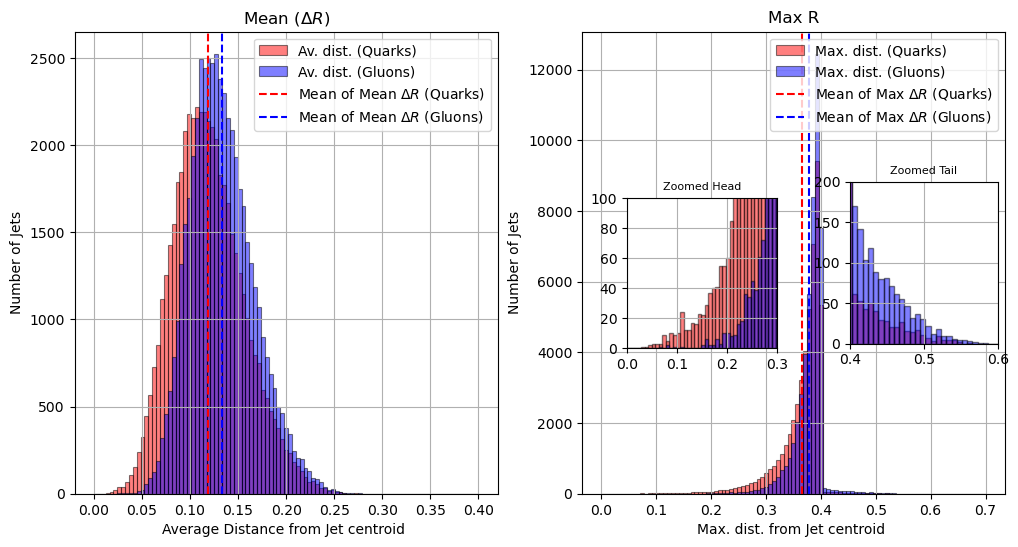

In [31]:

# delta R


def deltaR_dist(X_val, y_val, label):
    """
    Computes spatial distance of each particle from its jet centroid (in η-φ space),
    along with per-jet average and maximum ΔR values.

    Args:
        X_val (np.ndarray): Jet data (n_jets, n_particles, 3) with pT, η, φ
        y_val (np.ndarray): Jet labels (0 = gluon, 1 = quark)
        label (int): 0 (gluon jets) or 1 (quark jets)

    Returns:
        Tuple:
            - delta_R_flattened (np.ndarray): All ΔR values across all jets
            - mean_delta_Rs (List[float]): Mean ΔR per jet
            - max_delta_Rs (List[float]): Max ΔR per jet
    """
    
    delta_R_all = []
    mean_delta_Rs = []
    max_delta_Rs = []
    
    for i in range(len(X_val)):
        if y_val[i] == label:
            # Extracting non-zero values and filtering out zero-padded values
            pT = X_val[i, X_val[i, :, 0]> 0, 0]
            eta = X_val[i, X_val[i, :, 0]> 0, 1]
            phi = X_val[i, X_val[i, :, 0]> 0, 2]
        
            if pT.size > 0:
                # Computing eta_bar and phi_bar (pT weighted mean)
                eta_bar = np.sum(pT * eta) / np.sum(pT)
                phi_bar = np.sum(pT * phi) / np.sum(pT)

                # Computing eucledean distance from centroid (eta_bar, phi_bar) for each particle in jet and for all jets
                delta_phi = np.arctan2(np.sin(phi - phi_bar), np.cos(phi - phi_bar))
                delta_R = np.sqrt((eta - eta_bar)**2 + delta_phi**2)
                delta_R_all.append(delta_R)
                
                # Mean delta R
                mean_delta_Rs.append(np.mean(delta_R))

                # Max delta R
                max_delta_Rs.append(np.max(delta_R))
                
    delta_R_flattened = np.concatenate(delta_R_all)
                
    return delta_R_flattened, mean_delta_Rs, max_delta_Rs


deltaR_quark_all, deltaR_quark_mean, deltaR_quark_max = deltaR_dist(X_val, y_val, 1)
deltaR_gluon_all, deltaR_gluon_mean, deltaR_gluon_max = deltaR_dist(X_val, y_val, 0)

# print(f"ΔR (Quark): Min = {np.min(deltaR_quark_all):.4f}, Max = {np.max(deltaR_quark_all):.4f}")
# print(f"ΔR (Gluon): Min = {np.min(deltaR_gluon_all):.4f}, Max = {np.max(deltaR_gluon_all):.4f}")

print(f"Mean ΔR (Quark): Min. val. = {np.min(deltaR_quark_mean):.4f}, Max. val. = {np.max(deltaR_quark_mean):.4f}")
print(f"Mean ΔR (Gluon): Min. val. = {np.min(deltaR_gluon_mean):.4f}, Max. val = {np.max(deltaR_gluon_mean):.4f}")

print(f"Max ΔR (Quark): Min. val. = {np.min(deltaR_quark_max):.4f}, Max. val. = {np.max(deltaR_quark_max):.4f}")
print(f"Max ΔR (Gluon): Min. val. = {np.min(deltaR_gluon_max):.4f}, Max. val. = {np.max(deltaR_gluon_max):.4f}")


# Visualizing
fig, ax = plt.subplots(1, 2, figsize=(12,6))
bins_mean = np.linspace(0, 0.4, 100)
bins_max = np.linspace(0, 0.7, 100)


ax[0].hist(deltaR_quark_mean, bins=bins_mean, alpha=0.5, label='Av. dist. (Quarks)', color ='red', edgecolor='black', linewidth=0.8
)
ax[0].hist(deltaR_gluon_mean, bins=bins_mean, alpha=0.5, label='Av. dist. (Gluons)', color='blue', edgecolor='black', linewidth=0.8
)
ax[0].set_xlabel("Average Distance from Jet centroid ")
ax[0].set_ylabel("Number of Jets")
ax[0].set_title("Mean ($\\Delta R$)")
ax[0].axvline(np.mean(deltaR_quark_mean), color="red", linestyle="--", label="Mean of Mean $\Delta R$ (Quarks)")
ax[0].axvline(np.mean(deltaR_gluon_mean), color="blue", linestyle="--", label="Mean of Mean $\Delta R$ (Gluons)")
ax[0].legend()
ax[0].grid(True)




ax[1].hist(deltaR_quark_max, bins=bins_max, alpha=0.5, label= 'Max. dist. (Quarks)', color ='red', edgecolor='black', linewidth=0.8
)
ax[1].hist(deltaR_gluon_max, bins=bins_max, alpha=0.5, label= 'Max. dist. (Gluons)', color='blue', edgecolor='black', linewidth=0.8
)
ax[1].set_xlabel("Max. dist. from Jet centroid ")
ax[1].set_ylabel("Number of Jets")
ax[1].set_title("Max R")
ax[1].axvline(np.mean(deltaR_quark_max), color="red", linestyle="--", label="Mean of Max $\Delta R$ (Quarks)")
ax[1].axvline(np.mean(deltaR_gluon_max), color="blue", linestyle="--", label="Mean of Max $\Delta R$ (Gluons)")
ax[1].legend()
ax[1].grid(True)

# Importing inset_axis
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Creating inset inside ax[1]
inset_ax1 = inset_axes(ax[1], width="35%", height="35%", loc="center right")

# Plotting same data inside inset
inset_ax1.hist(deltaR_quark_max, bins=bins_max,alpha=0.5, label='Max. dist. (Quarks)', color="red", edgecolor='black')
inset_ax1.hist(deltaR_gluon_max, bins=bins_max, alpha=0.5, label='Max. dist. (Gluons)', color="blue", edgecolor='black')

# Zoom limits
inset_ax1.set_xlim(0.4, 0.6)
inset_ax1.set_ylim(0, 200)
inset_ax1.set_title("Zoomed Tail", fontsize=8)
inset_ax1.grid(True)

# Creating inset inside ax[1]
inset_ax2 = inset_axes(
    ax[1],
    width=1.5,  # width as percent of parent axes
    height=1.5,
    loc='lower left',  # still needed to define anchor point
    bbox_to_anchor=(0.09, 0.3, 1, 1),  # fine-tune x, y position
    bbox_transform=ax[1].transAxes
)

# Plotting same data inside inset
inset_ax2.hist(deltaR_quark_max, bins=bins_max,alpha=0.5, label='Max. dist. (Quarks)', color="red", edgecolor='black')
inset_ax2.hist(deltaR_gluon_max, bins=bins_max, alpha=0.5, label='Max. dist. (Gluons)', color="blue", edgecolor='black')

# Zoom limits
inset_ax2.set_xlim(0, 0.3)
inset_ax2.set_ylim(0, 100)
inset_ax2.set_title("Zoomed Head", fontsize=8)
inset_ax2.grid(True)

# import seaborn as sns

# sns.histplot(deltaR_quark_mean, bins=100, color="black", kde=True, label="Quarks", stat="count", ax=ax[0])
# sns.histplot(deltaR_gluon_mean, bins=100, color="brown", kde=True, label="Gluons", stat="count", ax=ax[0])
# plt.legend()


#### ΔR Distributions from Jet Centroid

### Feature Description
- For each jet, we computed the **Euclidean distance** in $\eta-\phi$ space between each particle and the jet's $p_{T}$-weighted center.
- From this, we extracted two key per-jet features:
  - **Mean $\Delta R$**: Average particle spread around the jet center.
  - **Max $\Delta R$**: Farthest particle from the jet center.

### Observations from Histograms
- **Quark jets** tend to have **lower mean and max $\Delta R$**, indicating tighter, more collimated structure.
- **Gluon jets** show **broader $\Delta R$ distributions**, with a longer tail in max ΔR.
- The **zoomed inset plots** further highlight that:
  - Quark jets have denser cores.
  - Gluon jets more often contain particles spread further out.

### Interpretation
- These ΔR-based spatial features reveal internal structure **beyond global averages** like $p_{T}$ or $\eta$-width.
- The visual differences are clear even without statistical testing:
  - The ΔR distributions are **asymmetric**, **shifted**, and **more diffuse for gluons**.
- This reinforces that gluon jets are more spread out, while quark jets are sharply peaked.

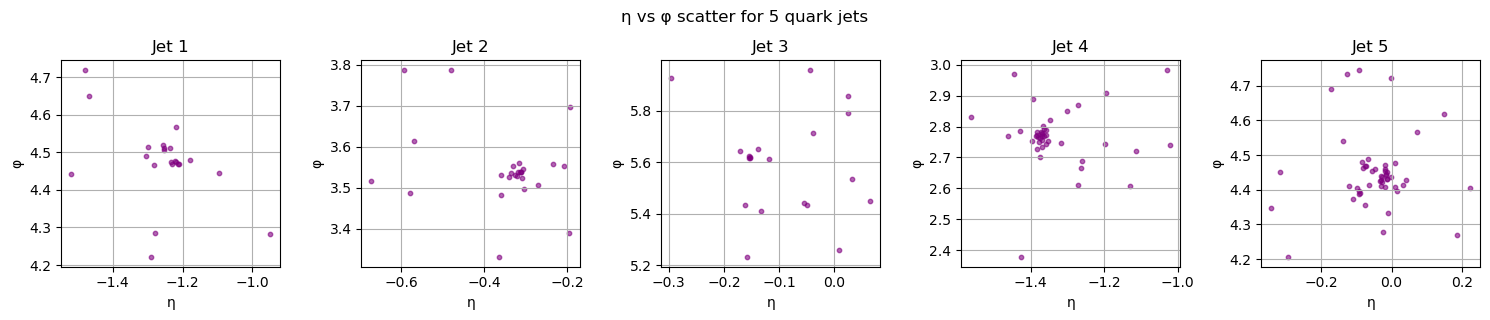

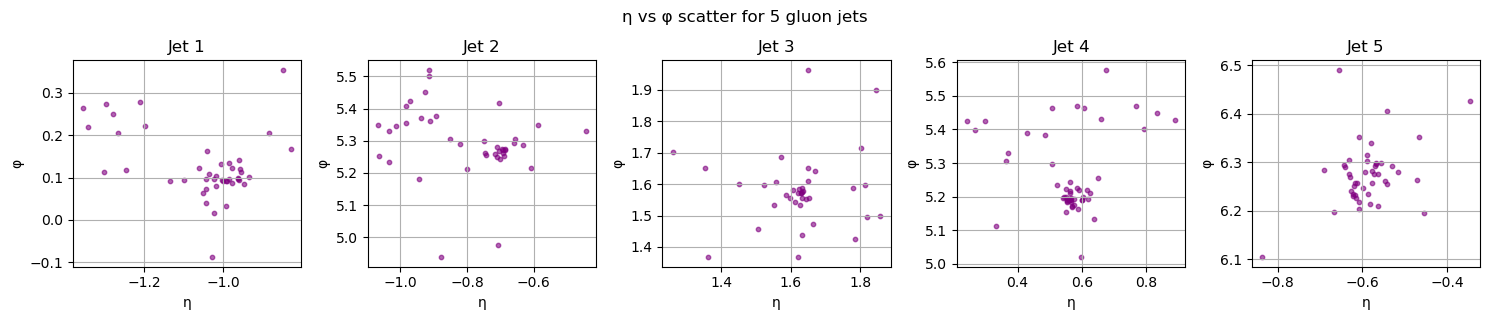

In [32]:
#### Scatter Plot

def scatter_plot_eta_phi(X_val, y_val, label):
    """
    Plots η vs. φ scatter for particles in selected jets of a given label.
    
    Args:
        X_val (np.ndarray): Jet data array with shape (n_jets, n_particles, 3)
        y_val (np.ndarray): Corresponding jet labels (0 = gluon, 1 = quark)
        label (int): Jet class to filter (0 or 1)
    """
    plt.figure(figsize=(15, 3))
    count = 0
    
    for i in range(len(X_val)):
        if y_val[i] == label:
            jet = X_val[i]
            mask = jet[:, 0] > 0  # remove zero pT entries
            eta = jet[mask, 1]
            phi = jet[mask, 2]

            plt.subplot(1, 5, count + 1)
            plt.scatter(eta, phi, alpha=0.6, s=10, color='purple')
            plt.xlabel('η')
            plt.ylabel('φ')
            plt.title(f'Jet {count + 1}')
            plt.grid(True)

            count += 1
            
        if count == 5:
            break
    
    plt.tight_layout()
    plt.suptitle(f"η vs φ scatter for 5 {'quark' if label==1 else 'gluon'} jets", y=1.05)
    plt.show()


# For quark jets
scatter_plot_eta_phi(X_val, y_val, label=1)

# For gluon jets
scatter_plot_eta_phi(X_val, y_val, label=0)


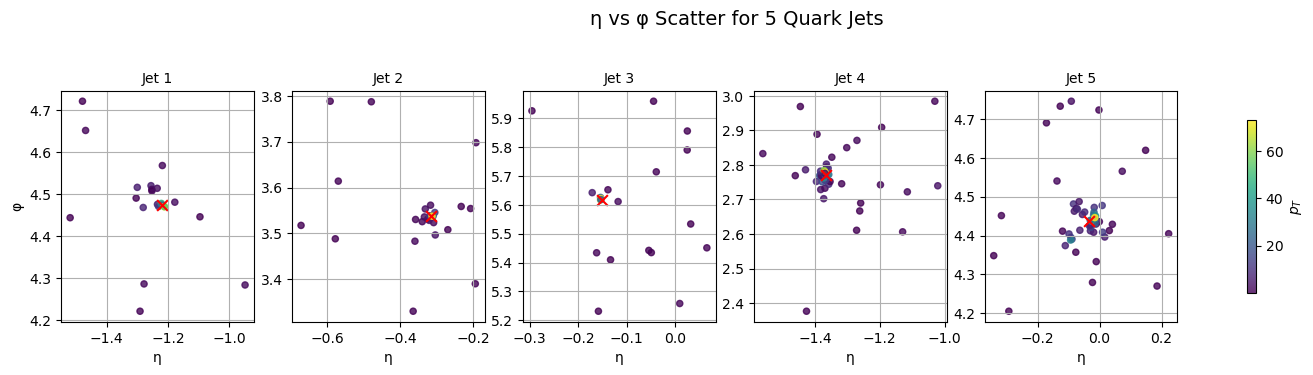

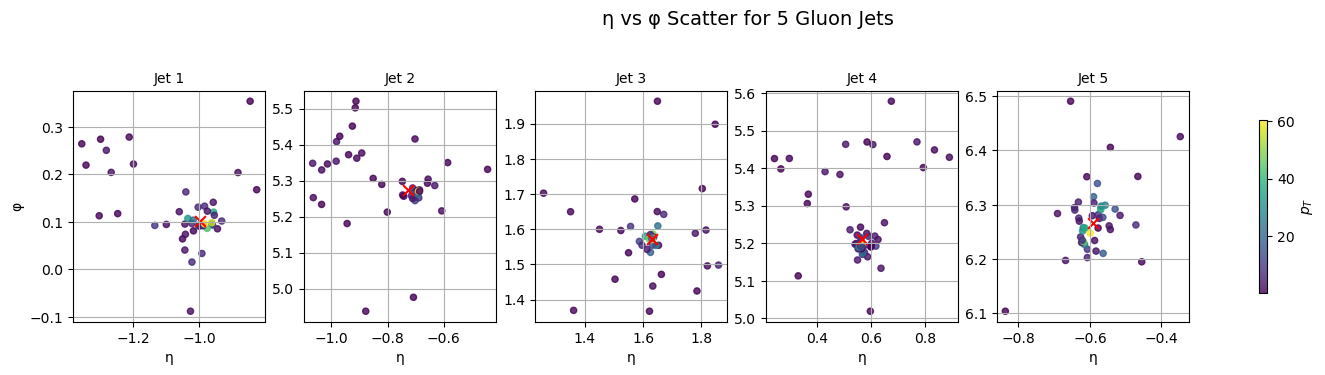

In [33]:
#### Scatter plot - coloured by pT and marked with centroid

def scatter_plot_eta_phi_pT(X_val, y_val, label):
    """
    Plots η vs. φ scatter for particles in 5 selected jets of a given label,
    colored by pT and annotated with jet centroid.

    Args:
        X_val (np.ndarray): Jet data array with shape (n_jets, n_particles, 3)
        y_val (np.ndarray): Corresponding jet labels (0 = gluon, 1 = quark)
        label (int): Jet class to filter (0 = gluon, 1 = quark)
    """
    fig, axes = plt.subplots(1, 5, figsize=(18, 3))
    fig.suptitle(f"η vs φ Scatter for 5 {'Quark' if label==1 else 'Gluon'} Jets", fontsize=14, y=1.15)

    count = 0
    for i in range(len(X_val)):
        if y_val[i] == label:
            jet = X_val[i]
            mask = jet[:, 0] > 0
            pT = jet[mask, 0]
            eta = jet[mask, 1]
            phi = jet[mask, 2]

            # Centroid
            eta_bar = np.sum(pT * eta) / np.sum(pT)
            phi_bar = np.sum(pT * phi) / np.sum(pT)

            ax = axes[count]
            sc = ax.scatter(eta, phi, c=pT, cmap='viridis', s=20, alpha=0.8)
            ax.scatter(eta_bar, phi_bar, color='red', marker='x', s=60, label='Centroid')
            ax.set_title(f"Jet {count+1}", fontsize=10)
            ax.set_xlabel('η')
            if count == 0:
                ax.set_ylabel('φ')
            ax.grid(True)
            count += 1

            if count == 5:
                break

    # Add colorbar
    cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), shrink=0.75, label=r"$p_T$")
    # plt.tight_layout()
    plt.show()


# For quark jets
scatter_plot_eta_phi_pT(X_val, y_val, label=1)

# For gluon jets
scatter_plot_eta_phi_pT(X_val, y_val, label=0)

In [34]:
# Statistics

def summarize_stats_deltaR(values):
    mean_val = np.mean(values)
    median_val = np.median(values)
    std_val = np.std(values)
    skew_val = skew(values)
    kurtosis_val = kurtosis(values)
    return mean_val, median_val, std_val, skew_val, kurtosis_val


# Printing the statistics in tabular format
deltaR_stats = {
    "Metric": ["Mean", "Median", "Std", "Skew", "Kurtosis"],
    "deltaR_quark_all": summarize_stats_deltaR(deltaR_quark_all),
    "deltaR_gluon_all": summarize_stats_deltaR(deltaR_gluon_all),
}

deltaR_df = pd.DataFrame(deltaR_stats).round(4)

print(deltaR_df.to_string(index=False))

  Metric  deltaR_quark_all  deltaR_gluon_all
    Mean            0.1255            0.1377
  Median            0.0865            0.1067
     Std            0.1131            0.1086
    Skew            0.8331            0.7473
Kurtosis           -0.5062           -0.5514


### Particle-Level Jet Structure Analysis: Summary Statistics of $\Delta R$

We computed descriptive statistics for the spatial distance $\Delta R$ of each particle from its jet centroid in $\eta$-$\phi$ space, separately for quark and gluon jets.

---

### Summary Table
| Metric       | $\Delta R$ (Quark Jets) | $\Delta R$ (Gluon Jets) |
|--------------|--------------------------|---------------------------|
| **Mean**     | 0.1255                   | 0.1377                    |
| **Median**   | 0.0865                   | 0.1067                    |
| **Std Dev**  | 0.1131                   | 0.1086                    |
| **Skewness** | 0.8331                   | 0.7473                    |
| **Kurtosis** | -0.5062                  | -0.5514                   |

---

### Key Observations

- **Gluon jets** have **higher average and median $\Delta R$**, confirming their **diffuse structure**.
- **Quark jets** have **lower central values** but **greater skewness**, suggesting that:
  - Most particles are tightly clustered (collimated core)
  - A few particles stray farther, causing a longer tail in the distribution.
- Surprisingly, quark jets show slightly higher **standard deviation** than gluon jets. This could be due to occasional wide-angle emissions.
- Both distributions are **platykurtic (kurtosis < 0)**:
  - Flatter peak than a normal distribution
  - Tails are thin — indicating few extreme outliers.

---

These statistical patterns support and deepen our visual findings from the scatter plots. Let's proceed to analyze the empirical **CDF** and **Kolmogorov-Smirnov test** to quantify the **distinguishability** of quark vs. gluon jets using $\Delta R$.



KS Statistic ΔR : 0.0964
P-value ΔR: 0.000000


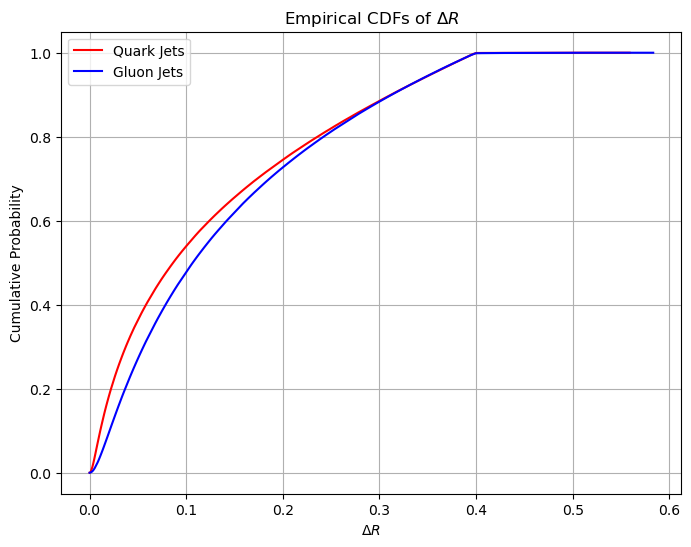

In [42]:
# Empirical CDF

# from scipy.stats import ks_2samp

# sorting and computing the empirical cdf
def empirical_cdf_deltaR(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

deltaR_quark_sorted, deltaR_quark_cdf = empirical_cdf_deltaR(deltaR_quark_all)
deltaR_gluon_sorted, deltaR_gluon_cdf = empirical_cdf_deltaR(deltaR_gluon_all)


# Plot the CDFs
plt.figure(figsize=(8, 6))


plt.plot(deltaR_quark_sorted, deltaR_quark_cdf, label="Quark Jets", color="red")
plt.plot(deltaR_gluon_sorted, deltaR_gluon_cdf, label="Gluon Jets", color="blue")
plt.xlabel("$\Delta R$")
plt.ylabel("Cumulative Probability")
plt.title("Empirical CDFs of $\\Delta R$")
plt.legend()
plt.grid(True)


# KS Test
ks_stat_deltaR, p_value_deltR = ks_2samp(deltaR_quark_all, deltaR_gluon_all)


print(f"KS Statistic ΔR : {ks_stat_deltaR:.4f}")
print(f"P-value ΔR: {p_value_deltR:.6f}")



## KS Test on Particle-Level $\Delta R$ Distributions

### Observations
- We computed the **empirical CDFs** for all particle-level $\Delta R$ values in quark and gluon jets.
- The **KS test** revealed a **statistically significant** difference:
  - **KS Statistic**: `0.0964`
  - **P-value**: `0.000000`

### Interpretation
- Although significant, the **KS statistic is lower** than what we saw for jet-wise mean/max $\Delta R$.
- This is because:
  - The test compares **all particles pooled together** across jets.
  - Most particles in both quark and gluon jets tend to be **near the jet core**.
  - Only a few particles are far out — especially in gluon jets — but their effect is **diluted** in the massive list of $\Delta R$ values.
- As a result, **particle-level $\Delta R$ distribution appears more similar**, even though **per-jet structure differs strongly**.

### Conclusion
- **Global particle-level $\Delta R$ is a weak classifier** by itself.
- But it helps us understand **why per-jet $\Delta R$ mean and max are better discriminators**.
- This underscores the importance of engineering features **at the right level** (jet vs particle).


# Phase 2: Jet-wise and Particle-wise Feature Engineering Summary

This phase combined statistical hypothesis testing with physics-driven feature extraction at both **jet-level** and **particle-level**, to uncover meaningful differences between quark and gluon jets.

---

## Jet-Wise Feature Engineering (Global Summary Features)

We began by computing per-jet global features to characterize each jet as a whole.

### Engineered Features:
- **Jet $p_T$**: Total transverse momentum
- **$p_T$-weighted Jet Width in $\eta$**: Spread of constituents in pseudorapidity
- **$p_T$-weighted Jet Width in $\phi$**: Spread of constituents in azimuth

### Statistical Tools Used:
- Descriptive statistics (mean, std, skew, kurtosis)
- **Kolmogorov-Smirnov (KS) Test** to compare quark vs. gluon distributions
- **Empirical CDFs** to visualize separation

### Key Findings:
- **$p_T$ is significantly higher for quark jets**, confirmed by KS statistic of 0.063.
- **$p_T$-weighted jet widths in $\eta$ and $\phi$ showed strong separation**:
  - KS Statistic (Jet Width $\eta$): ~0.37
  - KS Statistic (Jet Width $\phi$): ~0.37
- These widths are more powerful than $p_T$ in separating jet types.

### Physical Insight:
- Quark jets are more **collimated**, consistent with their lower jet width.
- Gluon jets are more **diffuse**, due to higher color charge and radiation.

---

## Particle-Level Feature Engineering (Jet Shape Analysis)

To dig deeper, we analyzed **internal particle structure** of jets using the **spatial distance** from jet centroids:

### Engineered Feature:
- **$\Delta R$ of each particle from the jet centroid** in $\eta$-$\phi$ space
- Per-jet **mean** and **max** $\Delta R$

### Tools Used:
- 2D **scatter plots** of $\eta$ vs. $\phi$ for individual jets
- **Color-coded by $p_T$** to understand energy flow
- Descriptive statistics on all $\Delta R$ values
- Empirical CDF + KS Test on particle-level $\Delta R$

### Key Findings:
- Quark jets have **lower mean and max $\Delta R$** → more compact core
- Gluon jets have **larger spread and occasional far particles**
- Descriptive stats revealed:
  - Quark jets: Mean $\Delta R$ = 0.1255, Skew = 0.83
  - Gluon jets: Mean $\Delta R$ = 0.1377, Skew = 0.74
- KS Statistic (all-particle $\Delta R$): **0.0964** → significant but less than jet width

### Physical Insight:
- Jet width (summary feature) exaggerates collimation difference
- Particle-level $\Delta R$ shows **core-halo structure** and occasional strays in quark jets

---

## Summary of Phase 2:
I successfully:
- Engineered **features** at both jet and particle level
- Visualized, quantified, and statistically validated quark-gluon differences
- Revealed that **jet width features are powerful**, but **internal jet structure offers complementary insights**

These features form a **strong input set for machine learning**, where we can now test whether classifiers can exploit both global and fine-grained differences to distinguish jets.


In [46]:
# saving pt 
pt_quark = []
pt_gluon = []

for i in range(len(X_val)):
    if y_val[i] == 1:  # quark
        pt = X_val[i, X_val[i, :, 0] > 0, 0]
        pt_quark.append(np.sum(pt))
    elif y_val[i] == 0:  # gluon
        pt = X_val[i, X_val[i, :, 0] > 0, 0]
        pt_gluon.append(np.sum(pt))

pt_quark = np.array(pt_quark)
pt_gluon = np.array(pt_gluon)

# Saving data

np.savez("engineered_features.npz",
         deltaR_quark_all=deltaR_quark_all,
         deltaR_gluon_all=deltaR_gluon_all,
         deltaR_quark_mean=deltaR_quark_mean,
         deltaR_gluon_mean=deltaR_gluon_mean,
         deltaR_quark_max=deltaR_quark_max,
         deltaR_gluon_max=deltaR_gluon_max,
         eta_width_quark=eta_width_quark,
         eta_width_gluon=eta_width_gluon,
         phi_width_quark=phi_width_quark,
         phi_width_gluon=phi_width_gluon,
         pt_quark=pt_quark,
         pt_gluon=pt_gluon)